<center>
<h1>Do financial statements influence stock prices</h1>
<h2>The case of Goldman Sachs</h2>
</center>

   #   Group member

### ZHOU shiming            
### Caspar MOSER

<h2 id="df">Introduction</h2>

We are interested in the short term effect a financial statement published by a company has on the companies stock price. We use a multiple linear regression model similar to the model proposed by <a href="#ref">Patell [1976]</a>.

Our data consists of daily stock price changes of the banking institution Goldman Sachs and the KBW index, an index of the thirty biggest banks in the United States over a given period of time. Note that Goldman Sachs is not part of it. Furthermore, we add a dummy variable that indicates for any date during the time interval wether or not GS published a certain type of financial statement on that date. We end up with a data frame with three variables in <i>n</i> dates. We then regress the daily stock price change of Goldman and Sachs on the change of the KBW index and on the dummy. As opposed to <a href="#ref">Patell [1976]</a> we use daily changes instead of weekly changes, we do not regress on a constant (doing so would lead to coefficient near zero) and we ignore dividend payouts. 

## Plan

1) Data acquiring
- Scrapping of the stock prices
- Data cleaning and index change
- Creation of the approximate percentage change variable
- Scrapping of the financial statements
- Data processing for the prepration of the regression

2) Analysis
- Regression using statsmodels
- Explanation of procedure
- Discussion of results

3) Visualization
- Plotting using seaborn
- Interpretation

In [1]:
#some useful packages
import requests
import re
import pandas as pd
import json
from pandas import DataFrame as df

import datetime
from datetime import date
from datetime import datetime
import time

import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.axes

/Users/joe/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1) Data acquring

We used two different website to scrap our data from.

The first one is <a href="http://www.goldmansachs.com/investor-relations/financials/archived">Goldman Sachs Financials</a>. On this page the bank lists all of its financial statements with their respective publication dates since 1999. Furthermore it is possible to only show certain types of financial statements. This detailed representation does not seem to be, according to our findings, very common. Other companies do not show publication dates on their websites. This is the main reason why we chose to analyse Goldman Sachs.

The second one is <a href="https://finance.yahoo.com">Yahoo! Finance</a>. Here we scrapped the daily closing prices of Goldman Sachs in the KBW index over a give period of time. 

### Scrapping of the stock prices

First of all, we get all the data that we need from the website of yahoo finance.
We choose to use the package of request to get the inital text data and we use the package re to interpret the content and store all the information that we need into a list. The function <i>date_to_seconds</i>, which uses the datetime and the time package, allows us to scrap the information not only for any company or index but also any time period (supposing that data is available) from Yahoo! Finance. Later on we will restrict ourselves on Goldman Sachs in the KBW index. 



In [2]:
def date_to_seconds(x):
    t = datetime.strptime(x, '%Y-%m-%d')
    u = time.mktime(t.timetuple())
    v = int(u)
    return v

def retrieve_quotes_historical(stock_code, t1, t2):
    date1 = date_to_seconds(t1)
    date2 = date_to_seconds(t2)
    quotes = []
    r = requests.get('https://finance.yahoo.com/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter=history&frequency=1d'.format(*[stock_code, date1, date2]))
    m = re.findall('"HistoricalPriceStore":{"prices":(.*?),"isPending"', r.text)
    if m :
        quotes = json.loads(m[0])
        quotes = quotes[::-1]
    return [item for item in quotes if not 'type' in item]

### Data cleaning and index change
In a second step we get rid of unneccessary variables and transform the index of our data frame(s) to the corresponding dates, using the package datetime. We change the date to seconds and the transform it to the form we want to use which is "yyyy-mm-dd".

In [3]:
def rewrite_quotes(stock_code, t1, t2):
    quotes = retrieve_quotes_historical(stock_code, t1, t2)
    list1 = []
    for i in range(len(quotes)):
        x = date.fromtimestamp(quotes[i]['date'])
        y = date.strftime(x,'%Y-%m-%d')
        list1.append(y)
    quotesdf_ori = df(quotes, index = list1)
    quotes = quotesdf_ori.drop(['open','high','low','volume','adjclose','date'], axis = 1)
    return quotes

### Creation of the approximate percentage change variable

We rewrote the closing price of both GS and KBW to get the approximate percentage change to the day before using the following formula:


<center><h5>approximate percentage change on date t = log(closing price on date t / closing price on date t-1)</h5>.</center>

In [4]:
def cal_divide_one_day(x):
    #returns for a numpy array the corresponding values of the formula
    close_divide2 = []
    close_divide = np.array(x)
    for i in range(len(close_divide)-1):
        close_divide2.append(math.log(close_divide[i+1]/close_divide[i]))
    close_divide2.insert(0,0)    #on the first date we define the change as 0
    return close_divide2

def regression_prep(stock_code, t1, t2):
    D = rewrite_quotes(stock_code, t1, t2)
    D['percentage_change'] = cal_divide_one_day(D.close) #here we create the new variable using the function above
    F = D.drop('close', axis=1)
    return F

### Scrapping of the financial statements
We still need a dummy variable which indicates for any date if GS published a financial statement. In this function we first get the data from yahoo! finance, only to get the exact all the dates. We used the KBW index for no specific reason. The Goldman Sachs stock would have done the job too. Then, we scrap from the Goldman Sachs website all dates in the form that we need. The way the page is build, this corresponds only to the dates where a financial statement is published. Then we create a list with the length of the KBW dataframe and elements, where all elements are zero. Then we change an argument in the list to one, if the argument at the same position of the KBW dataframe index is also on the website. This way we get the dummy variable we need. The function reutrns a dataframe with the date index and the dummy variable.  Note, that we introduce a new argument, the type argument. To be more specific, this is the type of financial statement. The following types are published on the websites:

- 'quarterly-earnings-releases'
- 'annual-reports'
- 'proxy-statements'
- '10k'
- '10q'
- '8k'
- '8k-exhibits'
- 'subsidiary-financial-info/gsi'
- 'subsidiary-financial-info/gsec'
- 'subsidiary-financial-info/gsco'
- 'subsidiary-financial-info/gsbank-usa'
- 'subsidiary-financial-info/gsib'
- 'subsidiary-financial-info/other'
- 'other-information'
- 'xblr'

In [5]:
def retrieve_reports_for_dummy(type, t1, t2):
    KBW = regression_prep('^BKX', t1, t2)
    url = 'http://www.goldmansachs.com/investor-relations/financials/archived/%s/index.html'%(type)
    m = requests.get(url)
    a_list = re.findall('<time datetime="(.*?)">',m.text)
    a = np.array(a_list)
    b_list = []
    for i in range(len(KBW)):
        b_list.append(0)
    for i in range(len(a)):
        for j in range(len(KBW)):
            if a[i] in KBW.index[j]:
                b_list[j] = 1
    b = np.array(b_list)
    D = df(index = KBW.index)
    D['dummy'] = b
    return D

### Data processing for the prepration of the regression
In a last step of our first part we actually srcap the data for Goldman Sachs and KBW, as well as the dummy and create a new data frame containing all three variables. We call them 'GS_change' for the change of the Goldman Sachs stock, 'KBW_change' for the change of the index and 'dummy' for the dummy vairable. Also we drop all dates with missing values which is neccessary for the regression.

In [6]:
def regression_prep_2(type, t1, t2):
    GS = regression_prep('GS', t1, t2)
    KBW = regression_prep('^BKX', t1, t2)
    D = retrieve_reports_for_dummy(type, t1, t2)
    D['GS_change'] = GS.percentage_change
    D['KBW_change'] = KBW.percentage_change
    D = D.dropna()
    return D

## 2) Analysis
At this point we are ready to perform the regression.
### Regression using statsmodels
We use the package statsmodels. We get our dataframe with the function <i>regression_prep_2</i>. Then, we split it into a dataframe X containing the two predicting variables 'KBW_change' and 'dummy' and a dataframe y containing the variable we want to regress, 'GS_change'. Then we use the function sm.OLS() to perform the regression. Then, we call the summary of our results to get a clear table, with all values we are interested in. 

In [7]:
def regression(type='quarterly-earnings-releases', t1='2010-01-01', t2='2016-12-31'):
    D = regression_prep_2(type, t1, t2)
    target = D.GS_change
    predict = D.drop('GS_change', axis=1)
    y = pd.DataFrame(target)
    X = predict
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary(title='Regression of GS_change on KBW_change and dummy')

### Explanation of procedure

In our regression function we use three variables, the type of financial statement and the starting and ending dates. The possible type arguments are listed in the part <b><i>scrapping of financial statements</i></b>. Possible time periods can start much earlier than 1999, but since financial statement publications on the website of Goldman Sachs only date back to 1999 it would not make sense to pick a date before 1999. It is worth noting that not all types are available since 1999. This has to be taken into account when picking a time period. We set as default values for our funtion the time span from January 1<sup>st</sup> 2010 until December 31<sup>st</sup> 2016 and the type quarterly earnings releases. The name 'quarterly earnings releases' is rather self explanatory. One of these statements is about ten pages long and summarizes Goldman Sachs' performance over the preceding 3 months and compares to figures of the year before. The information is clearly presented; we suppose that investors can easily retrieve the information and react to it quickly.
During our period of seven years, 28 quarterly earnings releases were published. We assume that the markets reaction on such a statement depends on the true information. However, investors cannot observe the absolute true information. They read the statement and observe the given information as well as a certain tone that we expect to be influential to a certain degree. Their decision is formed both by the given information and by the tone of the statement.
A possible third derterminant of investors decision making could be assumptions the investor makes about stock price developement, following the publication of a statement, that are independent of the content of the statement.

In [8]:
regression()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Regression of GS_change on KBW_change and dummy                
==============================================================================
Dep. Variable:              GS_change   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1460.
Date:                Thu, 04 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:33:46   Log-Likelihood:                 5510.9
No. Observations:                1759   AIC:                        -1.102e+04
Df Residuals:                    1757   BIC:                        -1.101e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dummy         -0.0064      0.002     -3.226      0.001      -0.010      -0.003
KBW_change     0.8650      0.016     54.037      0.000       0.834       0.896
==============================================================================
Omnibus:                      439.792   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9411.796
Skew:                          -0.633   Prob(JB):                         0.00
Kurtosis:                      14.261   Cond. No.                         8.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discussion of results
Our model consists of 1759 observations. Note that weekends and national holidays are not included. The R<sup>2</sup> is 62.4 %. This is the ratio of the variance that our model can explain. As the P-value of our F-test is given as 0.00, we can reject at a 5 % significance level the Null hypothesis that KBW_change and dummy do not overall influence GS_change.
Let us look at the the P-values of the given coefficients. Both are below 0.05, so we can reject in both cases the null hypothesis that the variable does not influence GS-change on a 5 % significance level. The KBW_change coefficient has value of 0.8650. This means, that, when no quarterly earnings release is published, a 1 % change of the KBW index leads to 0.865 % change of the stock price of Goldman Sachs. The dummy coefficient has a value of -0.0064. So the average percentage change of the Goldman Sachs stock price on publication days is 0.64 percentage points smaller compared to regular days, were no quarterly earnings release is published.
So over the years 2010 to 2016 the publication of a quarterly earnings release had on average a negative effect on the stock price. How can we interpret this result?
A first explanation could be, quite intuitively, that this effect follows in general a negative trend.
Another explanation could be that the result is due to pure coincidence.
Our data is far from optimal. We only analyze one company and we only analyze it during a specific time period. We do not have a random sample. As a result we cannot simply conclude that with a probability of 95 % the true value of the effect is in the confidence interval given in our results. To see this one can simply change the starting date to '2000-01-01'. The result will be a regression were we cannot reject the null hypothesis on a 5% significance level anymore. 
Another disadvantage is that we have a very small treatment group (if we say that the treatment is the publication of a quarterly earnings release), while we have a very large non-treatment group.

## 3)  Visualization
### Plotting using seaborn
We visualize our results by plotting a simple linear regression using only KBW_change as explanatory variable, while excluding the publication days from our data. In a second step we plot these excluded observations in a different colour.

In [9]:
sns.set(color_codes=True)
def plotreg(type='quarterly-earnings-releases', t1='2010-01-01', t2='2016-12-31'):
    D = regression_prep_2(type, t1, t2)
    X = D[D.dummy != 1] #exclude publication days
    Y = D[D.dummy != 0] #exclude non-punblication days
    sns.regplot(x='KBW_change', y='GS_change', data=X, color = 'b')
    plt.scatter(Y.KBW_change, Y.GS_change, color = 'red')
    red_Patch = mpatches.Patch(color = 'red', label = 'days of publication', alpha=0.7)
    b_Patch = mpatches.Patch(color = 'b', label = 'regular days')
    plt.legend(handles =[b_Patch,red_Patch])
    plt.xlabel('relative stock price change for KBW (logarithmic)')
    plt.ylabel('relative stock price change for GS (logarithmic)')
    return plt.show()

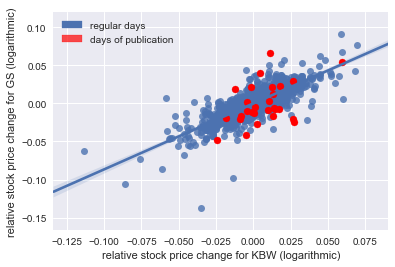

In [10]:
plotreg()

### Interpretation
The regression line has a positive slope with a parameter below one. It is visible, that the majority of the red dots lies below the regression line. One outlier is situated well above the line. This accords well with the results of our regression. 

## Conclusion
We were interested in the reaction of investors to the publication of a financial statement. We found out that, that during the years 2010 to 2016 the publication of a quarterly earnings release from the banking institution Goldman Sachs had a negative effect on its stock price. Due to the biasedness of our sample, we cannot conclude that the publication of a quarterly earnings release has in general a negative effect on the stock price of the company. The explanatory variables in our model can explain close to two thirds of the variance of the stock price change.

## Bibliography:
<a href='http://www.jstor.org/stable/2490543?casa_token=jWpN9IjGOgEAAAAA:RJhCtcE5BU_iZ_GMhs7rraznLTl7YnUCE0NyaANLvoyOrJ8MCCqAJqf4wnlk2gme5PkHUguVysfv0bkn56IhHBgj0--gijnTfh2eH0TsV5mxY27OcQ', id="ref">Patell, James M. "Corporate forecasts of earnings per share and stock price behavior: Empirical test." Journal of accounting research (1976): 246-276.</a>

## Contributions

### ZHOU Shiming : most part of the data scrapping and one part of the visualization

### Caspar MOSER: most part of the data processing and one part of the visualization